# Curvilinear grids in Devito

The symbolic API of Devito enables straightforward implementation of curvilinear transformations. Such transformations have multiple applications, including modelling of complex geometries, modelling in non-recilinear domains, and variable grid resolution. Transforming the partial differential equations (PDEs) from the physical space, onto a regular, rectilinear grid enables these equations to be solved via finite-difference, before inverse transforming back to the physical domain.

## Transforming PDEs

This notebook uses the isotropic acoustic wave equation to demonstrate the coordinate transformation of PDEs. Note however, that any PDE can be transformed in such a manner. The isotropic acoustic wave equation, where $p$ and $c$ are pressure and celerity repsectively, is as follows:

$\frac{\partial^2 p}{\partial t^2} = c\left(\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}\right)$.

Physical space dimensions $x$ and $z$ can be represented as functions of iteration dimensions $\gamma$ and $\zeta$:

$x = x(\gamma, \zeta)$,

$z = z(\gamma, \zeta)$.

Via the chain rule, the derivatives $\frac{\partial^2 p}{\partial x^2}$ and $\frac{\partial^2 p}{\partial y^2}$ can be written as derivatives in terms of $\gamma$ and $\zeta$:

$\frac{\partial^2 p}{\partial x^2} = \left(\frac{\partial^2 p}{\partial\gamma^2}\frac{\partial\gamma}{\partial x} + \frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\zeta}{\partial x}\right)\frac{\partial\zeta}{\partial x} + \frac{\partial p}{\partial\gamma}\frac{\partial^2\gamma}{\partial x^2} + \left(\frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\gamma}{\partial x} + \frac{\partial^2 p}{\partial\zeta^2}\frac{\partial\zeta}{\partial x}\right)\frac{\partial\zeta}{\partial x} + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial x^2}$,

$\frac{\partial^2 p}{\partial z^2} = \left(\frac{\partial^2 p}{\partial\gamma^2}\frac{\partial\gamma}{\partial z} + \frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\zeta}{\partial z}\right)\frac{\partial\zeta}{\partial z} + \frac{\partial p}{\partial\gamma}\frac{\partial^2\gamma}{\partial z^2} + \left(\frac{\partial^2 p}{\partial\gamma\partial\zeta}\frac{\partial\gamma}{\partial z} + \frac{\partial^2 p}{\partial\zeta^2}\frac{\partial\zeta}{\partial z}\right)\frac{\partial\zeta}{\partial z} + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial z^2}$.

Derivatives of iteration dimensions with respect to physical dimensions will depend on the transformation applied, and can be precalculated assuming the grid is not deformed with time. Note that depending on the transform applied, many of these terms will simplify.


## Variable grid resolution

The first application we will consider in this notebook is a variable resolution transformation. Such transformations enable grid resolution to be concentrated where it is needed, without oversampling of other areas of the domain and its associated cost. In seismic modelling, required resolution is dependent upon seismic wavespeeds which generally increase with depth. Consequently, a variable-z transformation is commonly used, stretching the grid vertically with depth to reduce the number of gridpoints required to discretise a given physical domain.

In this case, $x$ does not depend on $\zeta$, nor does $z$ depend on $\gamma$. Furthermore, $x$ and $\gamma$ are equivalent, thus simplifying the transformed derivatives to

$\frac{\partial^2 p}{\partial x^2} = \frac{\partial^2 p}{\partial\gamma^2}$

$\frac{\partial^2 p}{\partial z^2} = \frac{\partial^2 p}{\partial\zeta^2}\left(\frac{\partial\zeta}{\partial z}\right)^2 + \frac{\partial p}{\partial\zeta}\frac{\partial^2 \zeta}{\partial z^2}$.

In [1]:
# Necessary imports

import matplotlib.pyplot as plt
import numpy as np
import devito as dv

from scipy.signal import sawtooth
from scipy.ndimage import map_coordinates
from examples.seismic import Model, plot_velocity, TimeAxis, RickerSource

## Velocity model

The first step is to create a velocity model on a regular grid, for which a more optimal vertical resolution can be found. Whilst synthetic, this model aims to imitate the complexity found in real-world velocity models.

Operator `initdamp` ran in 0.01 s


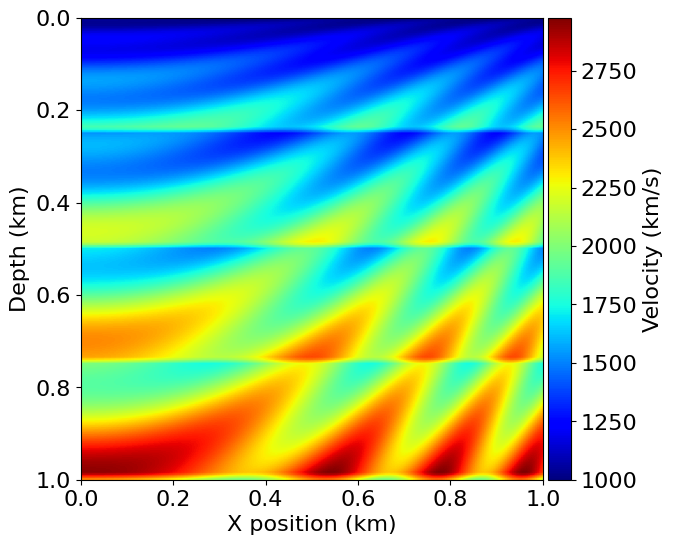

In [2]:
# Create grid values and a corresponding velocity model
x_vals = np.linspace(0., 1000., 201)
z_vals = np.linspace(0., 1000., 201)
mshx, mshz = np.meshgrid(x_vals/1000., z_vals/1000., indexing='ij')
c = 1200. + 1000.*mshz + 300.*mshz**0.5*(1+np.sin(20*mshx**2 + 40*mshz**0.5)) + 200.*sawtooth(8*np.pi*mshz, width=0.95)

# Parameterise the Devito grid
shape = (201, 201)
spacing = (5., 5.)
origin = (0., 0.)

model = Model(vp=c, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

To provide a reference for the wavefield propagated using a variable-z transform, we will first propagate a wavefield on the regular grid.

Operator `Kernel` ran in 0.05 s


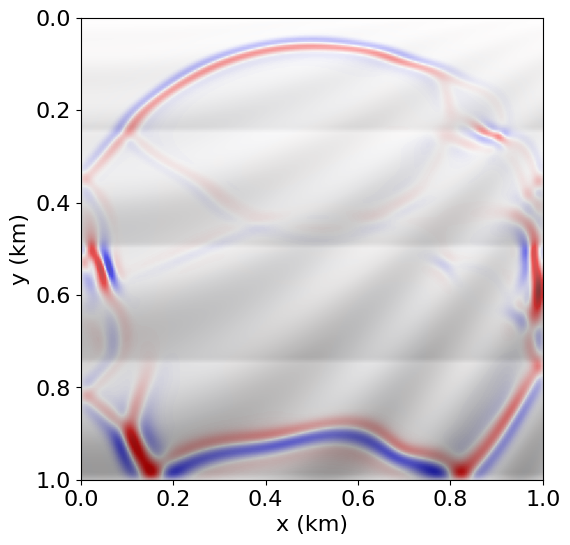

In [3]:
t0 = 0.  # Simulation starts a t=0
tn = 0.3  # Simulation last 0.3 seconds
dt = 0.8*model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 35.  # Source peak frequency is 35Hz
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range, interpolation='sinc')

# Center source
src.coordinates.data[0, :] = np.array(model.domain_size) * .5

# Set up fields
p = dv.TimeFunction(name='p', grid=model.grid, space_order=8, time_order=2)
pde = model.m * p.dt2 - p.laplace + model.damp * p.dt
stencil = dv.Eq(p.forward, dv.solve(pde, p.forward))

# Create injection term
src_term = src.inject(field=p.forward, expr=src)

# Assemble and run operator
op = dv.Operator([stencil] + src_term)
op.apply(dt=dt)

# Plot the wavefield against the velocity model
vmax = np.amax(np.abs(p.data[-1]))
extent = (0, 1, 1, 0)
plt.imshow(model.vp.data[10:-10, 10:-10].T, cmap='Greys', extent=extent)
plt.imshow(p.data[-1, 10:-10, 10:-10].T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax, extent=extent)
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.show()

## Calculating a stretch factor

The variable-z transform is based on the resolution required to resolve the shortest wavelength present at any given depth. Frequency, wavespeed, and wavelength ($f$, $v$, and $\lambda$ respectively) are related to one another via:

$v = f\lambda$.

A finite difference scheme can adequately resolve a wavefield sampled with some $\alpha$ points per shortest wavelength, this value depending upon the discretisation. As such, the required grid spacing is given by:

$\Delta z(z) = \frac{v_m(z)}{\alpha f_M}$,

where the subscripts $m$ and $M$ denote minimum and maximum values respectively. Reposing this as a stretch factor $\epsilon$ relative to the vertical grid spacing at $z=0$:

$\epsilon(z) = \frac{v_m(z)}{\alpha f_M \Delta z_0}$,

where

$\Delta z_0 = \frac{v_m(z_0)}{\alpha f_M}$,

thus

$\epsilon(z) = \frac{\Delta z(z)}{\Delta z_0} = \frac{v_m(z)}{v_m(z_0)}$.

For simplicity, we will use a linear function for $\epsilon(z)$. One could use a function with higher order curvature, or calculate derivatives of this function using finite differences however.

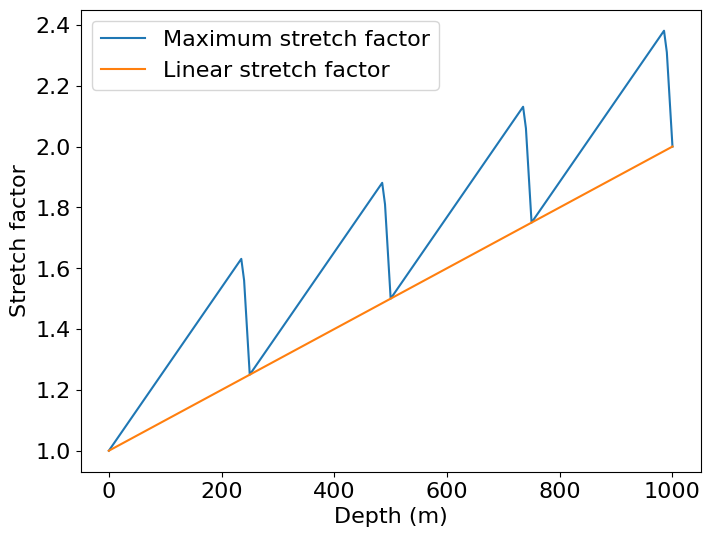

In [4]:
eps_opt = np.amin(c, axis=0)/np.amin(c[:, 0])  # Optimal stretch factor

# Best linear stretch factor
# Linear function means gradient of epsilon is a constant
epsdz = np.amin((eps_opt[1:] - eps_opt[0])/z_vals[1:])
eps = eps_opt[0] + z_vals*epsdz

plt.plot(z_vals, eps_opt, label="Maximum stretch factor")
plt.plot(z_vals, eps, label="Linear stretch factor")
plt.xlabel("Depth (m)")
plt.ylabel("Stretch factor")
plt.legend()
plt.show()

Given that

$\frac{\partial \zeta}{\partial z} = \frac{1}{\epsilon}$,

one can rearrange and integrate to obtain the mapping from $z$ to $\zeta$, this being

$\zeta = \left(\frac{\partial\epsilon}{\partial z}\right)^{-1}ln(\epsilon)$.

The reverse mapping can be obtained by rearranging this equation. The transformed derivatives contain both $\frac{\partial \zeta}{\partial z}$ and $\frac{\partial^2 \zeta}{\partial z^2}$, the latter of which can be expressed analytically:

$\frac{\partial^2 \zeta}{\partial z^2} = -\frac{1}{\epsilon^2}\frac{\partial\epsilon}{\partial z}$.

With this, we can calculate the reduction in gridpoints created by applying this vertical stretch.

In [5]:
def z_to_zeta(z):
    """Map from physical to the iteration space"""
    return (1/epsdz)*np.log(1 + epsdz*z)


def zeta_to_z(zeta):
    """Map from the iteration space to the physical"""
    return (np.exp(epsdz*zeta) - 1)/epsdz


# Get number of gridpoints in z direction with curvilinear grid
zeta_extent = z_to_zeta(1000.)
# Ratio of z extent to zeta extent is same as ratio of z size to zeta size, assuming equivalent sampling.
zeta_size = 1 + int(np.ceil(200*zeta_extent/1000.))

# Percentage reduction in grid size
percent_reduction = 100*(201 - zeta_size)/201
print("The curvilinear transformation reduces the number of gridpoints in the z dimension by %.2f%%" % percent_reduction)

The curvilinear transformation reduces the number of gridpoints in the z dimension by 30.35%


To parameterise the propagator on the curvilinear grid, it is necessary to resample the material parameters onto this grid. In this case, `scipy.ndimage.map_coordinates` is used to reinterpolate the velocity model.

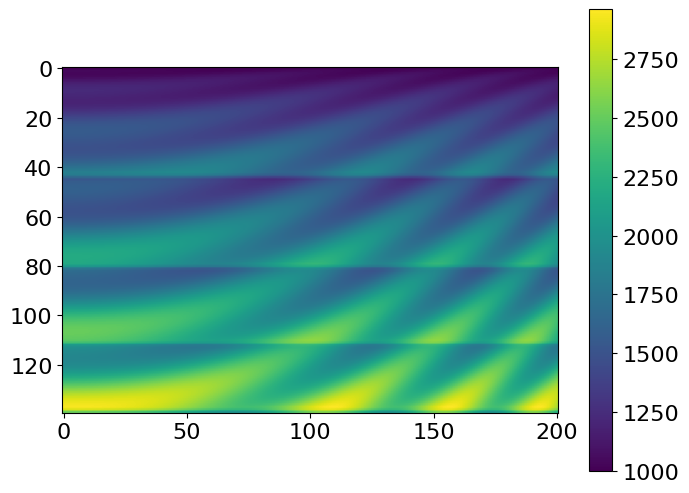

In [6]:
# Get the curvilinear grid and resample the model
zeta_vals = np.linspace(0., zeta_extent, zeta_size)
curvilinear_z_vals = zeta_to_z(zeta_vals)

mshgamma, mshzeta = np.meshgrid(x_vals, curvilinear_z_vals, indexing='ij')

# Coordinates expected in terms of grid increments, currently in terms of physical space
coordinates = np.vstack((200*mshgamma[np.newaxis]/1000., 200*mshzeta[np.newaxis]/1000.))
# Reinterpolate the velocity model
c_curv = map_coordinates(c, coordinates)

# Plot warped velocity field
plt.imshow(c_curv.T)
plt.colorbar()
plt.show()

Note how the layers which were evenly spaced in physical space are more tightly bunched at the bottom of the iteration space than the top. This is because each vertical increment in the iteration space represents a larger increment in the physical space as one moves downwards through the model.

We will now set up a new `Model` with a reduced number of points in the vertical direction

In [7]:
shape_curv = (201, zeta_size)
model_curv = Model(vp=c_curv, origin=origin, shape=shape_curv, spacing=spacing,
                   space_order=2, nbl=10, bcs="damp")

# Set up fields
p_curv = dv.TimeFunction(name='p', grid=model_curv.grid, space_order=8, time_order=2)

Operator `initdamp` ran in 0.01 s


As $\frac{\partial \zeta}{\partial z}$ and $\frac{\partial^2 \zeta}{\partial z^2}$ are functions of $\epsilon$, we need to define a 1D `Function` to store $\epsilon$ values.

In [8]:
# Epsilon needs to be interpolated onto the curvilinear grid
eps_curv = dv.Function(name='epsilon', shape=(model_curv.grid.shape[-1],),
                       dimensions=(model_curv.grid.dimensions[-1],))
eps_curv.data[:] = np.pad(map_coordinates(eps, (200*curvilinear_z_vals/1000.,)), 10, mode='edge')

# Expressions for dzeta/dz and d^2zeta/dz^2
zetadz = 1/eps_curv
zetadz2 = -epsdz/(eps_curv**2)

Now we can define the transformed $z$ derivative.

In [9]:
# Define the transformed derivative
# FIXME: Dimensions need correcting
pdz2 = p_curv.dy2*zetadz**2 + p_curv.dy*zetadz2

And thus the transformed PDE.

In [10]:
# Define the transformed PDE
pde_curv = model_curv.m * p_curv.dt2 - (p_curv.dx2 + pdz2) + model_curv.damp * p_curv.dt
stencil_curv = dv.Eq(p_curv.forward, dv.solve(pde_curv, p_curv.forward))

We also need to position the source correctly in the transformed space, as the physical centre no longer coincides with that of the iteration space.

In [11]:
src_curv = RickerSource(name='src', grid=model_curv.grid, f0=f0,
                        npoint=1, time_range=time_range, interpolation='sinc')

# Center source
src_curv.coordinates.data[0, 0] = 500.
src_curv.coordinates.data[0, 1] = z_to_zeta(500.)

src_term_curv = src_curv.inject(field=p_curv.forward, expr=src_curv)

Finally we can create the operator, run it, and plot the wavefield in the iteration space.

Operator `Kernel` ran in 0.05 s


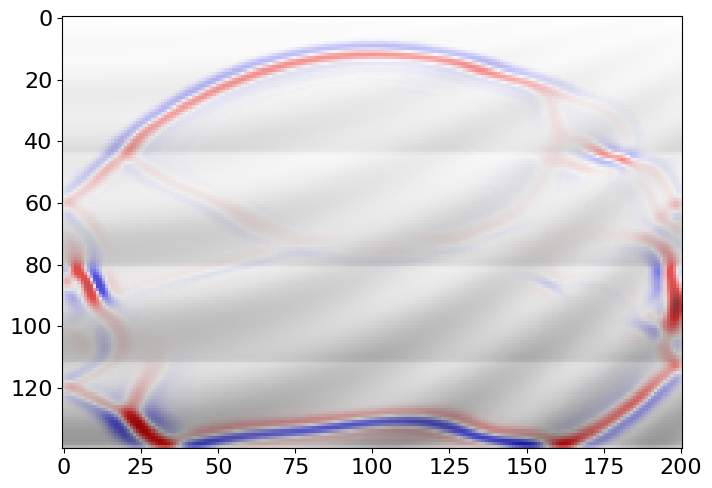

In [12]:
op_curv = dv.Operator([stencil_curv] + src_term_curv)
op_curv.apply(dt=dt)

vmax = np.amax(np.abs(p_curv.data[-1]))
plt.imshow(model_curv.vp.data[10:-10, 10:-10].T, cmap='Greys')
plt.imshow(p_curv.data[-1, 10:-10, 10:-10].T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax)
plt.show()

We can again use `scipy.ndimage.map_coordinates` to transform back to the physical domain for plotting.

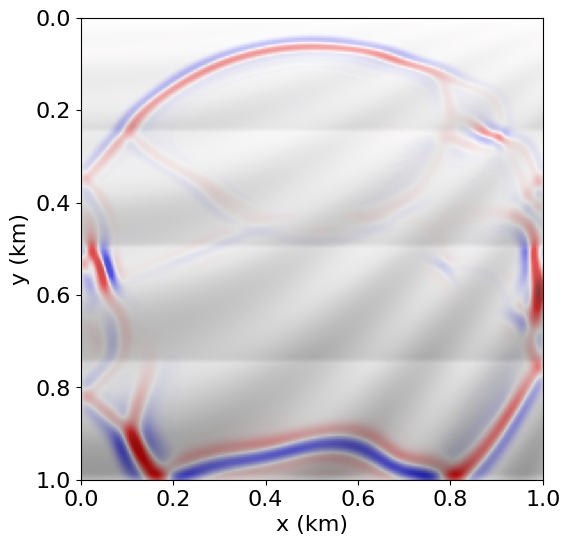

In [13]:
# Reverse the transformation for plotting in physical space
physical_zeta_vals = z_to_zeta(z_vals)

mshx_phys, mshz_phys = np.meshgrid(x_vals, physical_zeta_vals, indexing='ij')
coordinates = np.vstack((200*mshx_phys[np.newaxis]/1000., 200*mshz_phys[np.newaxis]/1000.))
p_phys = map_coordinates(p_curv.data[-1, 10:-10, 10:-10], coordinates)

vmax = np.amax(np.abs(p_phys))
extent = (0, 1, 1, 0)
plt.imshow(c.T, cmap='Greys', extent=extent)
plt.imshow(p_phys.T, cmap='seismic', alpha=0.6, vmax=vmax, vmin=-vmax, extent=extent)
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.show()

## Flattening transform

An alternative use of coordinate transforms is to map a complex geometry to a rectilinear iteration space. One such example is in the case of topographic variation in seismic modelling, wherein a flattening transform is used to map irregular topography to a horizontal in the iteration space. Whilst this approach can result in errors when accomodating rough topography (due to poor grid orthogonality), it is straightforward, and thus relatively common versus alternative approaches to curvilinear FD in these applications.